In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib
import mne
import plotly.express as px
import seaborn as sns
import pandas as pd
import xmltodict
import math

In [2]:
DEFAULT_CHANNEL_NAMES = ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3',       
                         'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1',       
                         'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz',       
                         'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2',       
                         'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 
                         'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'F9', 
                         'F10', 'A1', 'A2']

In [3]:
def mneRawFromHdf5(filepath, have_ch_names, sfreq, first_secs_to_trunc, trig_duration=0,trig_desc="Unknown", ref_ch=None):
    # Load data from hdf5 file and create MNE Raw Array
    hf = h5py.File(filepath, 'r')
    #print(hf.keys())
    data_array = np.divide(np.array(hf.get('RawData/Samples')).T,1e6)
    if have_ch_names:
        acq_task_desc = hf.get('RawData/AcquisitionTaskDescription')
        #print(xmltodict.parse(np.array(acq_task_desc)[0])['AcquisitionTaskDescription']['ChannelProperties']['ChannelProperties'])
        ch_num_name_lookup = {}
        ch_props = xmltodict.parse(np.array(acq_task_desc)[0])['AcquisitionTaskDescription']['ChannelProperties']['ChannelProperties']
        for prop in ch_props:
            #print(prop['LogicalChannelNumber']+', '+prop['ChannelName'])
            if prop['ChannelName']:
                ch_num_name_lookup[prop['LogicalChannelNumber']] = prop['ChannelName']
            else: 
                #print(prop['LogicalChannelNumber'])
                ch_num_name_lookup[prop['LogicalChannelNumber']] = DEFAULT_CHANNEL_NAMES[int(prop['LogicalChannelNumber'])-1]
        
        ch_names = [ch_num_name_lookup[num] for num in ch_num_name_lookup.keys()]
    else:
        ch_names = ['Channel' + str(i + 1) for i in range(data_array.shape[0])]
    
    ch_types = ['eeg' for i in range(data_array.shape[0])]
    eeg_info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)
    raw_eeg = mne.io.RawArray(data_array, eeg_info)

    # Re-reference data if reference channels are given
    if ref_ch:
        raw_eeg.set_eeg_reference(ref_channels=ref_ch)

    # Set annotations for triggers
    # Get times of triggers
    trig_times = (hf.get('AsynchronData/Time')[:]/sfreq).squeeze()
    # add anntations into the eeg data array
    durations = np.repeat(trig_duration,len(trig_times))

    if type(trig_desc) == str:
        descriptions = [trig_desc]*len(trig_times)
    elif type(trig_desc) == list:
        descriptions = trig_desc
    #print(descriptions)
    trig_annot = mne.Annotations(trig_times,durations,descriptions)
    raw_eeg.set_annotations(trig_annot)
    #print(raw_eeg.annotations)
    # crop the eeg data array for baseline signal removal
    #print(data_array.shape[1]/sfreq)
    raw_eeg.crop(tmin=first_secs_to_trunc, tmax=np.floor(data_array.shape[1]/sfreq))

    return raw_eeg

In [4]:
FIRST_SECS_TO_REMOVE = 90
trig_desc_lst = ['Eye_Close' if (i%2==0) else 'Eye_Open' for i in range(30)]
re_ref_motor_eeg = mneRawFromHdf5('EEG_data/eye reaction2024.04.15_11.24.09.hdf5', True, 512, FIRST_SECS_TO_REMOVE, 
                                  trig_desc=trig_desc_lst, ref_ch=['A1','A2'])

Creating RawArray with float64 data, n_channels=64, n_times=184327
    Range : 0 ... 184326 =      0.000 ...   360.012 secs
Ready.
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


In [5]:
def plotMNEData(mne_data, domain, scaling, plt_x_range, title, x_label, y_label, plt_method, 
                ch_not_to_show=[],save_plt_to='', show_trigger=False, show_plt=False):
    if domain == 'time':
        mne_data_df = mne_data.to_data_frame(scalings=scaling)
    elif domain == 'freq':
        mne_data_df = mne_data.to_data_frame(copy=True)
        # Scaling with 1e12 to micro-volt^2/Hz
        for col in mne_data_df.drop(['freq'],axis=1):
            mne_data_df[col] = mne_data_df[col]*1e12
    mne_data_df = mne_data_df[(mne_data_df[domain]>plt_x_range[0]) & (mne_data_df[domain]<plt_x_range[1])]
    if plt_method == 'plotly':
        fig = px.line(mne_data_df, x=domain, y=mne_data_df.drop(columns=[domain]+ch_not_to_show).columns,
                      title=title,labels={domain:x_label, 'value':y_label})
        if show_trigger and domain == 'time':
            for annot in mne_data.annotations:
                trig_x_pos = annot['onset']-FIRST_SECS_TO_REMOVE
                if trig_x_pos > mne_data_df[domain].iloc[0] and trig_x_pos < mne_data_df[domain].iloc[-1]:
                    fig.add_vline(x=trig_x_pos, line_width=1, line_dash="dash", line_color="green",
                                  annotation_text=f"{trig_x_pos:.2f}", annotation_position="top right")
        
        if save_plt_to:
            fig.write_html(save_plt_to)
        if show_plt:
            fig.show()
    
    elif plt_method == 'pyplot':
        plt.figure(figsize=(16, 15))
        #print(mne_data_df.drop(columns=[domain]+ch_not_to_show).head())
        plt.plot(mne_data_df[domain], mne_data_df.drop(columns=[domain]+ch_not_to_show))
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend(mne_data_df.drop(columns=[domain]+ch_not_to_show).columns, loc="best", prop={'size': 8})

        if show_trigger and domain == 'time':
            for annot in mne_data.annotations:
                trig_x_pos = annot['onset']-FIRST_SECS_TO_REMOVE
                if trig_x_pos > mne_data_df[domain].iloc[0] and trig_x_pos < mne_data_df[domain].iloc[-1]:
                    plt.axvline(x=trig_x_pos, color='r', linestyle='--')
                    # Show the value of the asynchron time, on the top of the lin
                    plt.text(trig_x_pos, plt.ylim()[1], f"{trig_x_pos:.2f}", rotation=45, verticalalignment='top')

                    
        if save_plt_to:
            plt.savefig(save_plt_to)
        if show_plt:
            plt.show()

In [6]:
def plotMNEArrSubplots(mne_eeg_arr,scaling,title,channel_names,time_range = (0,0),figure_size = (10,18),sfreq = 512, show_trigger=False):
    #plot the eeg data in four subplots(divide data into four parts)
    #display partial time only works for dataframe data

    eeg_df = mne_eeg_arr.to_data_frame(scalings=scaling)
    if time_range == (0,0):
        selected_time_data = eeg_df
    else:
        start,end = time_range
        selected_time_data = eeg_df[(eeg_df['time']>=start) & (eeg_df['time']<=end)]
    x = selected_time_data['time']
    y = selected_time_data.iloc[:,1:]

    #plt.figure(figsize=fig_size)
    fig, axs = plt.subplots(4,figsize= figure_size)
    fig.suptitle(title, y = 0.99)
    num_channels  = len(channel_names)
    NUM_COLORS = math.ceil(num_channels/4)
    num_remaining_channels = num_channels - (3*NUM_COLORS)
    sub_titles = ['First {} Channels'.format(NUM_COLORS),'Second {} Channels'.format(NUM_COLORS),'Third {} Channels'.format(NUM_COLORS),\
                   'Remaining {} Channels'.format(num_remaining_channels)]
    #cm = plt.get_cmap('gist_rainbow')
    colors = plt.cm.Spectral(np.linspace(0,1,NUM_COLORS))
    for i in range(4):
        axs[i].set_prop_cycle(color=colors)
        axs[i].plot(x,y.iloc[:,i*NUM_COLORS:(i+1)*NUM_COLORS])
        axs[i].set_title(sub_titles[i])
        axs[i].legend(channel_names[i*NUM_COLORS:(i+1)*NUM_COLORS],loc = 'upper right')
        axs[i].set_xlabel('Time [s]')
        axs[i].set_ylabel('Microvolts [mV]')

        if show_trigger:
            for annot in mne_eeg_arr.annotations:
                trig_x_pos = annot['onset']-FIRST_SECS_TO_REMOVE
                if trig_x_pos > eeg_df['time'].iloc[0] and trig_x_pos < eeg_df['time'].iloc[-1]:
                    axs[i].axvline(x=trig_x_pos, linewidth=1)
    fig.tight_layout()
    plt.show()

In [28]:
[ annot['onset'] for annot in re_ref_motor_eeg.annotations]

[94.8125,
 103.705078,
 112.628906,
 123.503906,
 132.410156,
 143.304688,
 152.210938,
 161.12695300000001,
 170.003906,
 178.910156,
 187.81054699999999,
 196.695312,
 206.62695300000001,
 215.503906,
 225.410156,
 234.310547,
 243.193359,
 252.126953,
 262.00390600000003,
 270.912109,
 281.828125,
 290.695312,
 298.603516,
 309.51171899999997,
 318.41015600000003,
 328.328125,
 337.1875]

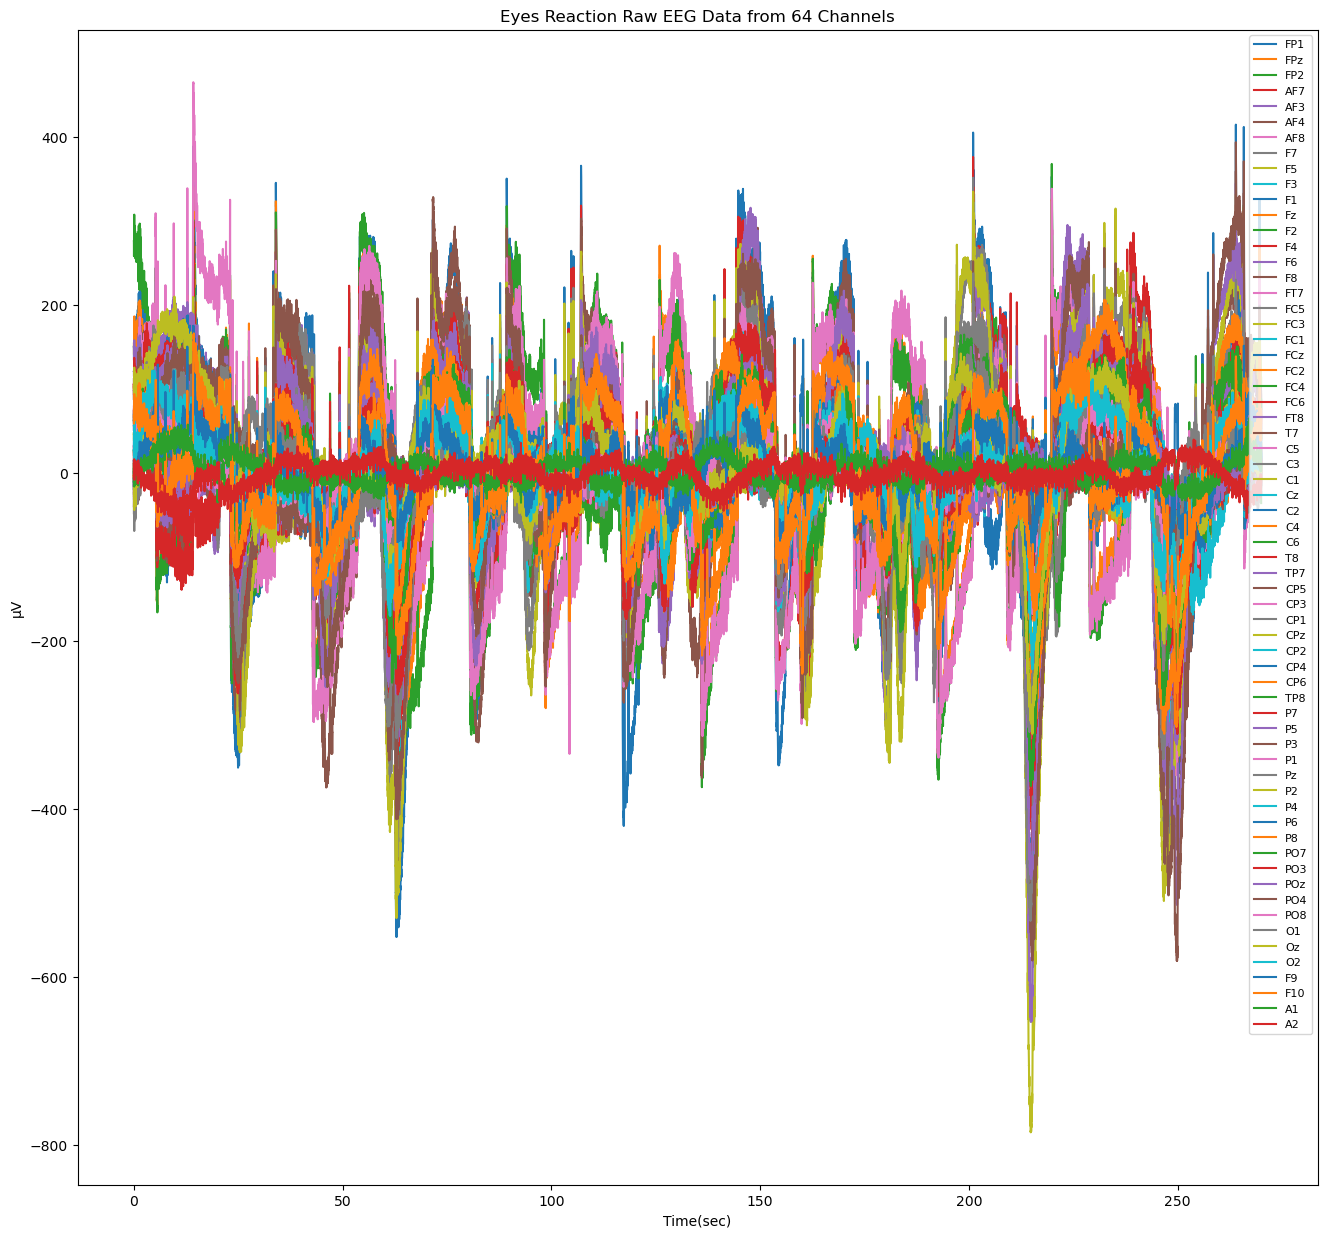

In [41]:
plotMNEData(mne_data=re_ref_motor_eeg, domain='time', scaling=1e6, plt_x_range=(0,300),
            title='Eyes Reaction Raw EEG Data from %d Channels'%(len(re_ref_motor_eeg.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            save_plt_to='motor_raw_eeg.png', show_trigger=False, show_plt=True)

In [7]:
def badChByCutoff(mne_eeg_arr, scaling, cutoff_amplitude, cutoff_ratio):
    eeg_df = mne_eeg_arr.to_data_frame(scalings=scaling)
    amp_volts = eeg_df.iloc[:,1:].abs()
    
    exceed_val_counts = amp_volts[amp_volts>=cutoff_amplitude].count()
    exceed_val_counts = exceed_val_counts[exceed_val_counts>0]
    #print(exceed_val_counts)
    
    exceed_val_ratio = (exceed_val_counts/len(eeg_df)).sort_values(ascending = True)
    #print(exceed_val_ratio)
    
    bad_channels = list(exceed_val_ratio[exceed_val_ratio>=cutoff_ratio].index)
    print(bad_channels)
    
    eeg_arr_dropped_bad_ch = mne_eeg_arr.copy().drop_channels(ch_names=bad_channels)
    return eeg_arr_dropped_bad_ch

In [8]:
# For eye reaction2024.04.15_11.24.09
motor_eeg_wo_bad_ch = badChByCutoff(re_ref_motor_eeg, 1e6, 500, 0.003)

['FP1', 'F3', 'F6', 'F7', 'F8', 'F5']


In [9]:
def badChByStd(mne_eeg_arr, scaling, std_tolerance=None):
    eeg_df = mne_eeg_arr.to_data_frame(scalings=scaling)
    sorted_std_ch = eeg_df.iloc[:,1:].std().sort_values(ascending = False)
    
    mean_of_std = sorted_std_ch.mean()
    print('mean value of channel std',mean_of_std)
    std_of_std = sorted_std_ch.std()
    print('std of channel std',std_of_std)
    print(sorted_std_ch[:10])

    if not std_tolerance:
        std_tolerance = std_of_std*0.1
        
    bad_channels = list(sorted_std_ch[sorted_std_ch>=(mean_of_std+3*std_of_std+std_tolerance)].index)
    print(bad_channels)
    
    eeg_arr_dropped_bad_ch = mne_eeg_arr.copy().drop_channels(ch_names=bad_channels)
    return eeg_arr_dropped_bad_ch

In [10]:
motor_eeg_wo_bad_ch = badChByStd(motor_eeg_wo_bad_ch, 1e6)

mean value of channel std 59.297200861087546
std of channel std 37.77034344779567
AF4    164.252102
FP2    159.526041
AF8    155.623429
FPz    148.147814
AF7    134.736646
AF3    127.409297
FC5    111.888411
F4     103.454482
FT8     97.544509
T8      93.330018
dtype: float64
[]


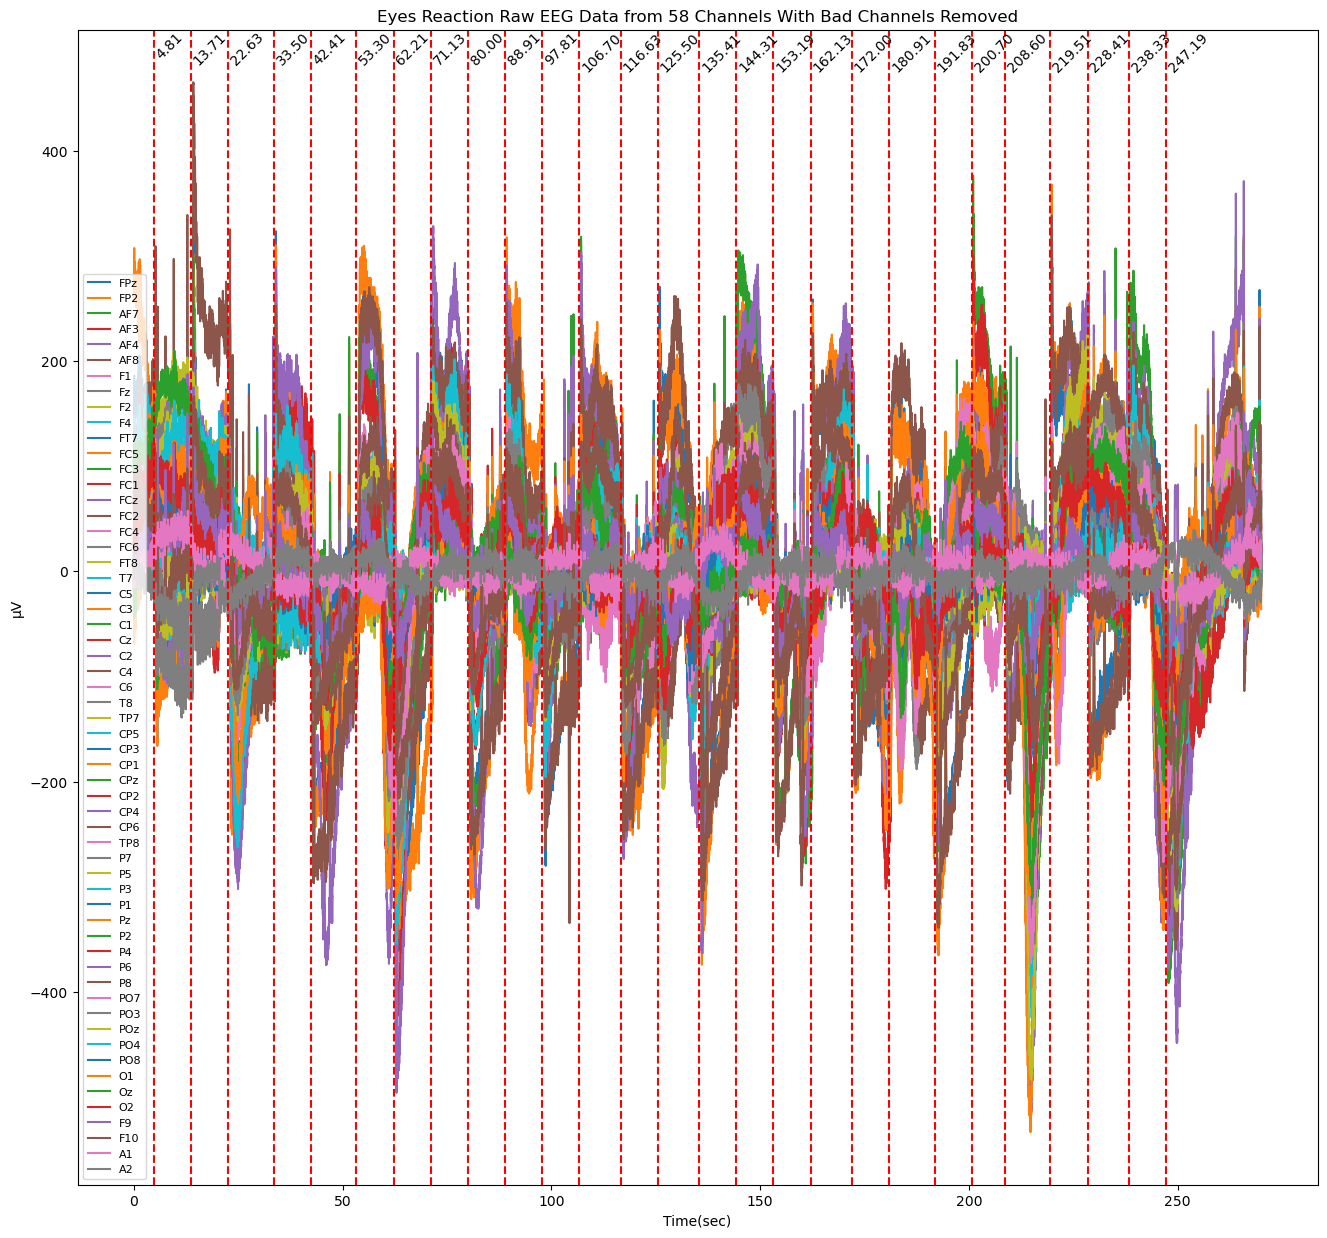

In [13]:
plotMNEData(mne_data=motor_eeg_wo_bad_ch, domain='time', scaling=1e6, plt_x_range=(0,300),
            title='Eyes Reaction Raw EEG Data from %d Channels With Bad Channels Removed'%(len(motor_eeg_wo_bad_ch.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            save_plt_to='motor_eeg_wo_bad_ch.png', show_trigger=True, show_plt=True)

In [11]:
# Band-pass and Notch filters
low_cut = 1
hi_cut  = 30
filtered_motor_eeg = motor_eeg_wo_bad_ch.copy().filter(low_cut,hi_cut)
filtered_motor_eeg = filtered_motor_eeg.copy().notch_filter(60, method='fir')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (3.303 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


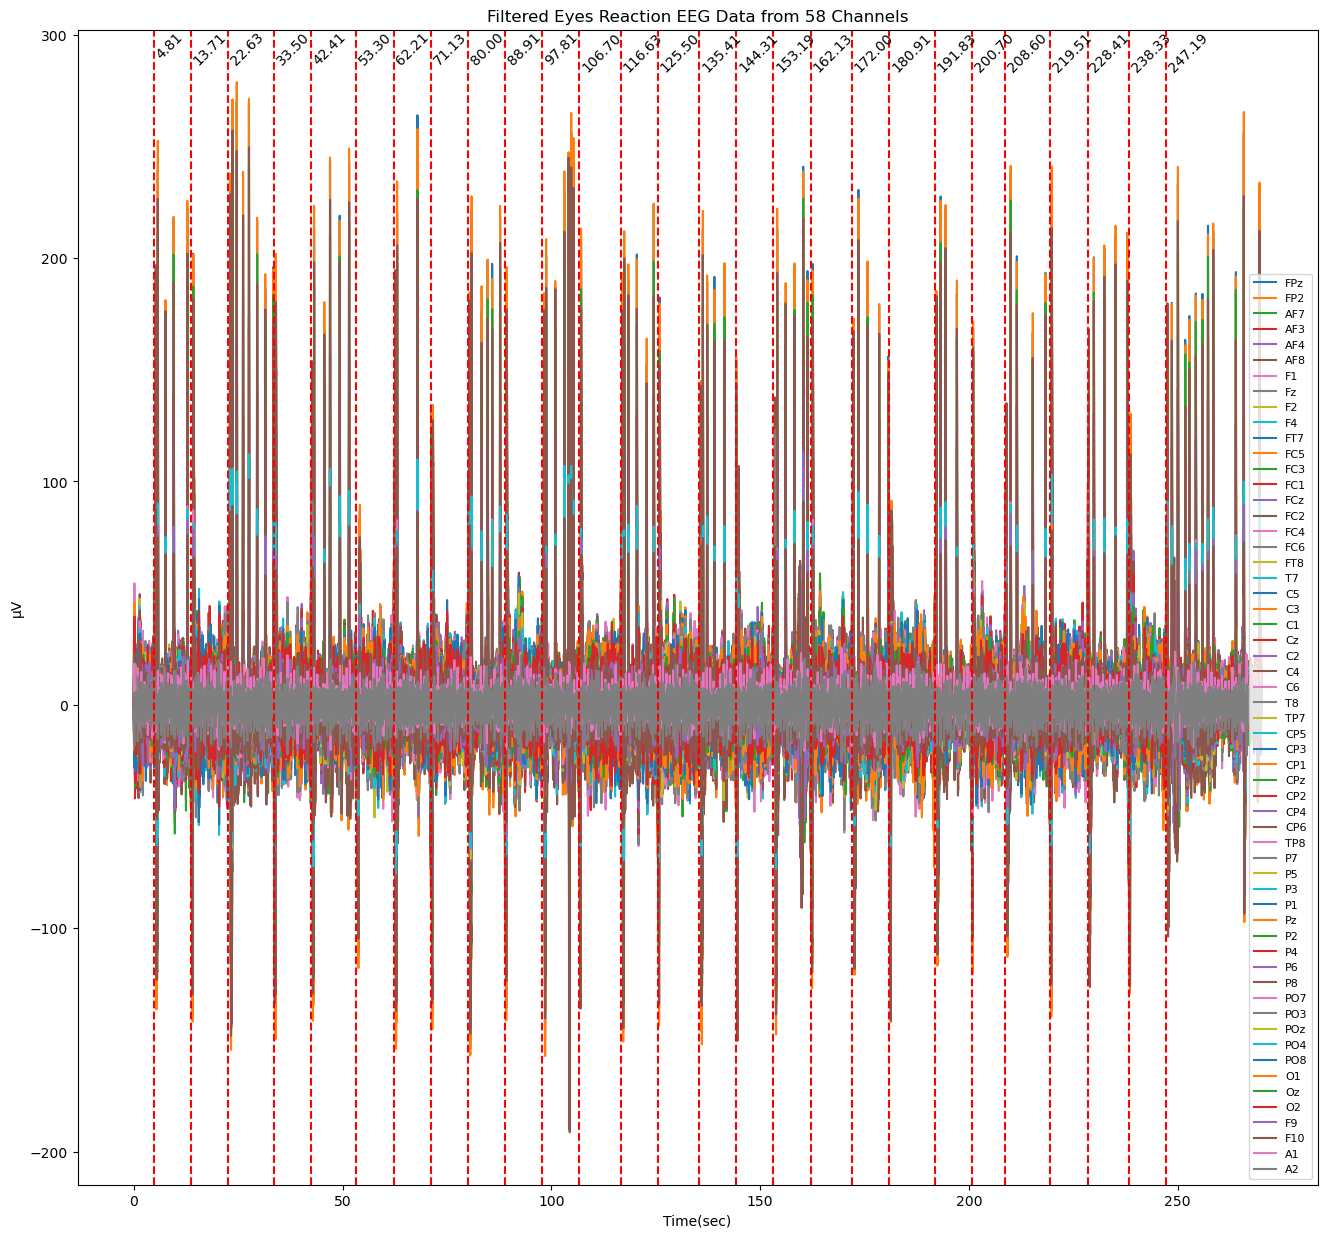

In [15]:
plotMNEData(mne_data=filtered_motor_eeg, domain='time', scaling=1e6, plt_x_range=(0,300),
            title='Filtered Eyes Reaction EEG Data from %d Channels'%(len(filtered_motor_eeg.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            save_plt_to='filtered_motor_eeg.png', show_trigger=True, show_plt=True)

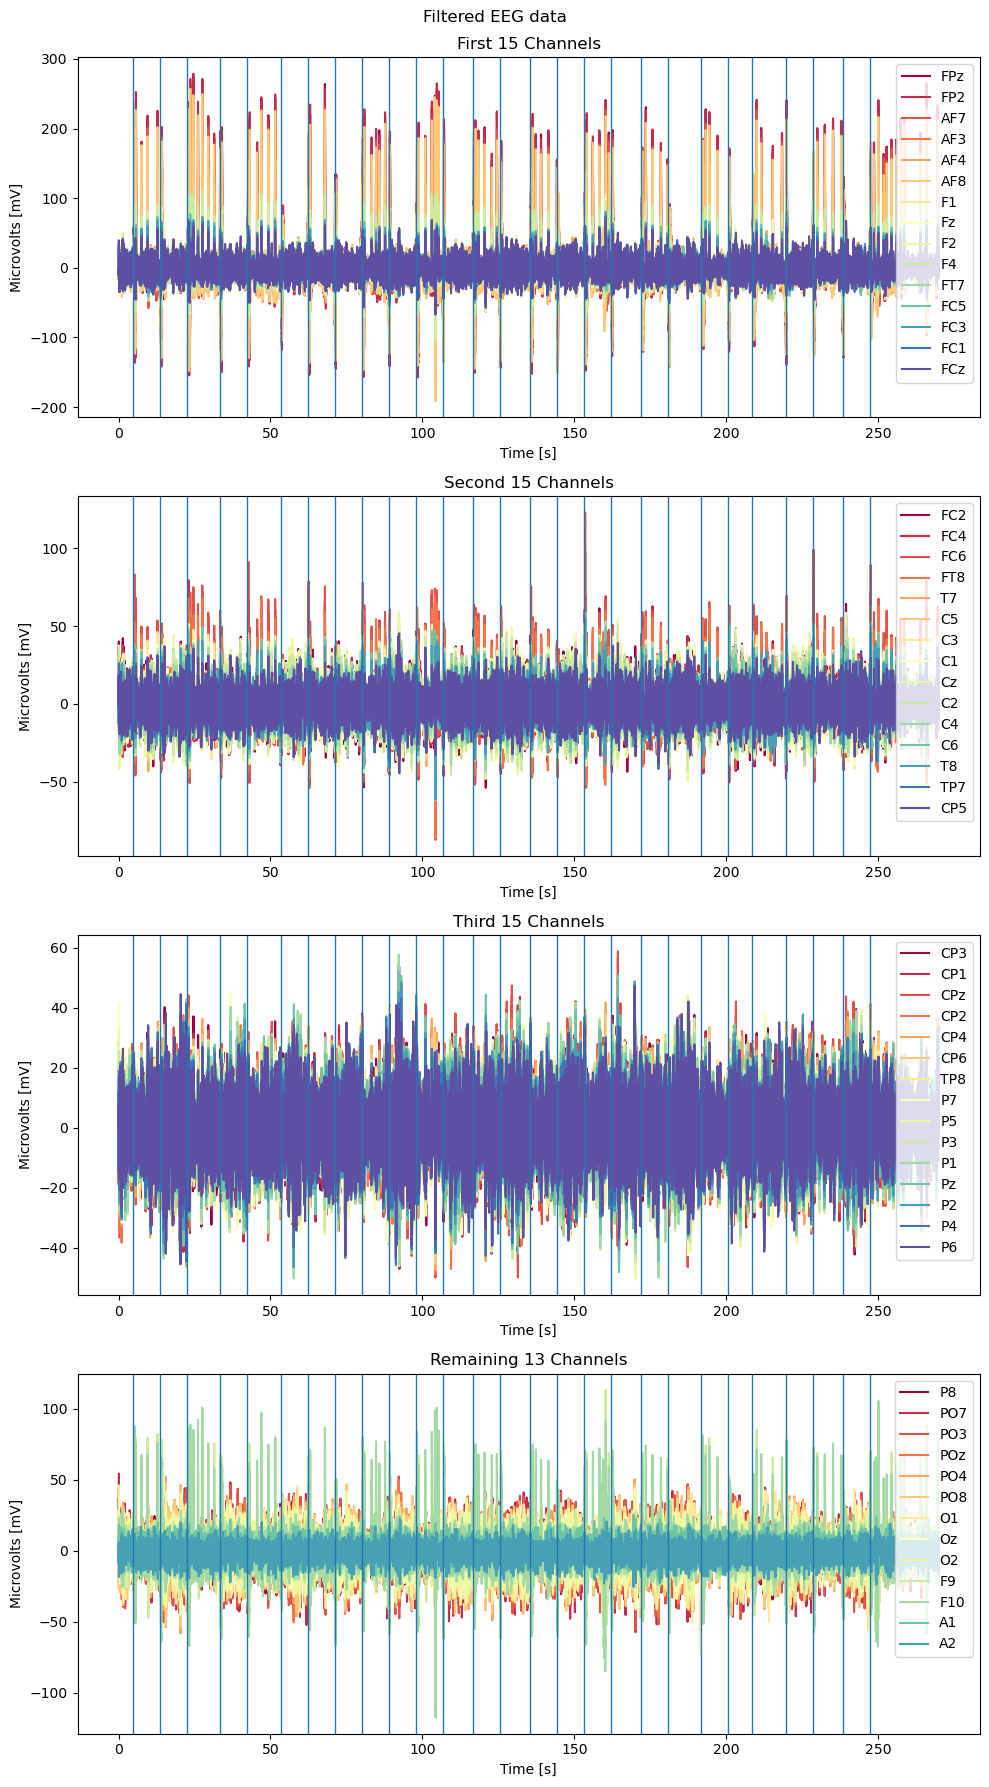

In [14]:
title = 'Filtered EEG data'
plotMNEArrSubplots(filtered_motor_eeg,1e6,title,filtered_motor_eeg.ch_names,show_trigger=True)

In [12]:
# Create ICA objects for eyes reation data by variance
motor_ica = mne.preprocessing.ICA(n_components=0.999, max_iter="auto", random_state=97)
motor_ica.fit(filtered_motor_eeg)

Fitting ICA to data using 58 channels (please be patient, this may take a while)
Selecting by explained variance: 45 components
Fitting ICA took 6.9s.


<ICA | raw data decomposition, method: fastica (fit in 55 iterations on 138241 samples), 45 ICA components (58 PCA components available), channel types: eeg, no sources marked for exclusion>

In [13]:
motor_ica.plot_sources(filtered_motor_eeg)

Creating RawArray with float64 data, n_channels=45, n_times=138241
    Range : 46080 ... 184320 =     90.000 ...   360.000 secs
Ready.
Using qt as 2D backend.


In [14]:
# For eye reaction2024.04.15_11.24.09
motor_comp_to_exclude = [0,1,2,3,4,5,14]#,26,29,33,34,35,36,37,41,42,43,44]

Applying ICA to Raw instance
    Transforming to ICA space (45 components)
    Zeroing out 7 ICA components
    Projecting back using 58 PCA components


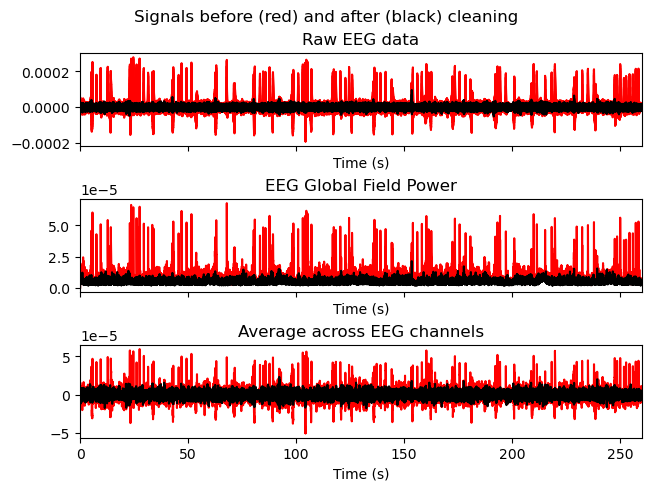

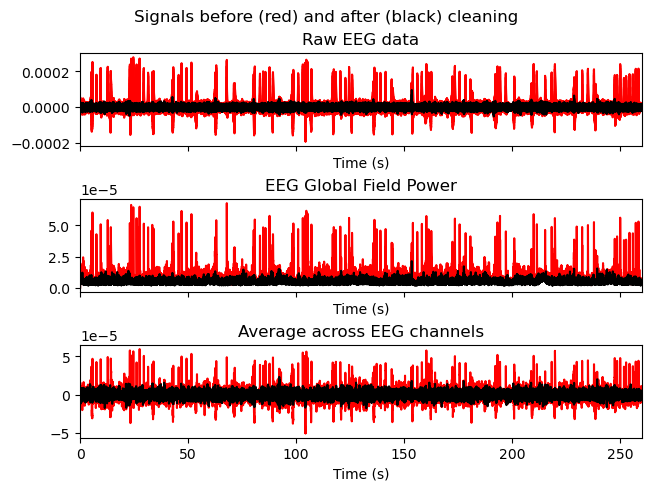

In [15]:
motor_ica.plot_overlay(filtered_motor_eeg, exclude=motor_comp_to_exclude,start=0, stop=133120)

In [16]:
# Set the components to exclude
motor_ica.exclude = motor_comp_to_exclude

In [17]:
# Actually apply the removal on the filtered data
motor_icaed_eeg = filtered_motor_eeg.copy()
motor_ica.apply(motor_icaed_eeg)

Applying ICA to Raw instance
    Transforming to ICA space (45 components)
    Zeroing out 7 ICA components
    Projecting back using 58 PCA components


<RawArray | 58 x 138241 (270.0 s), ~61.2 MB, data loaded>

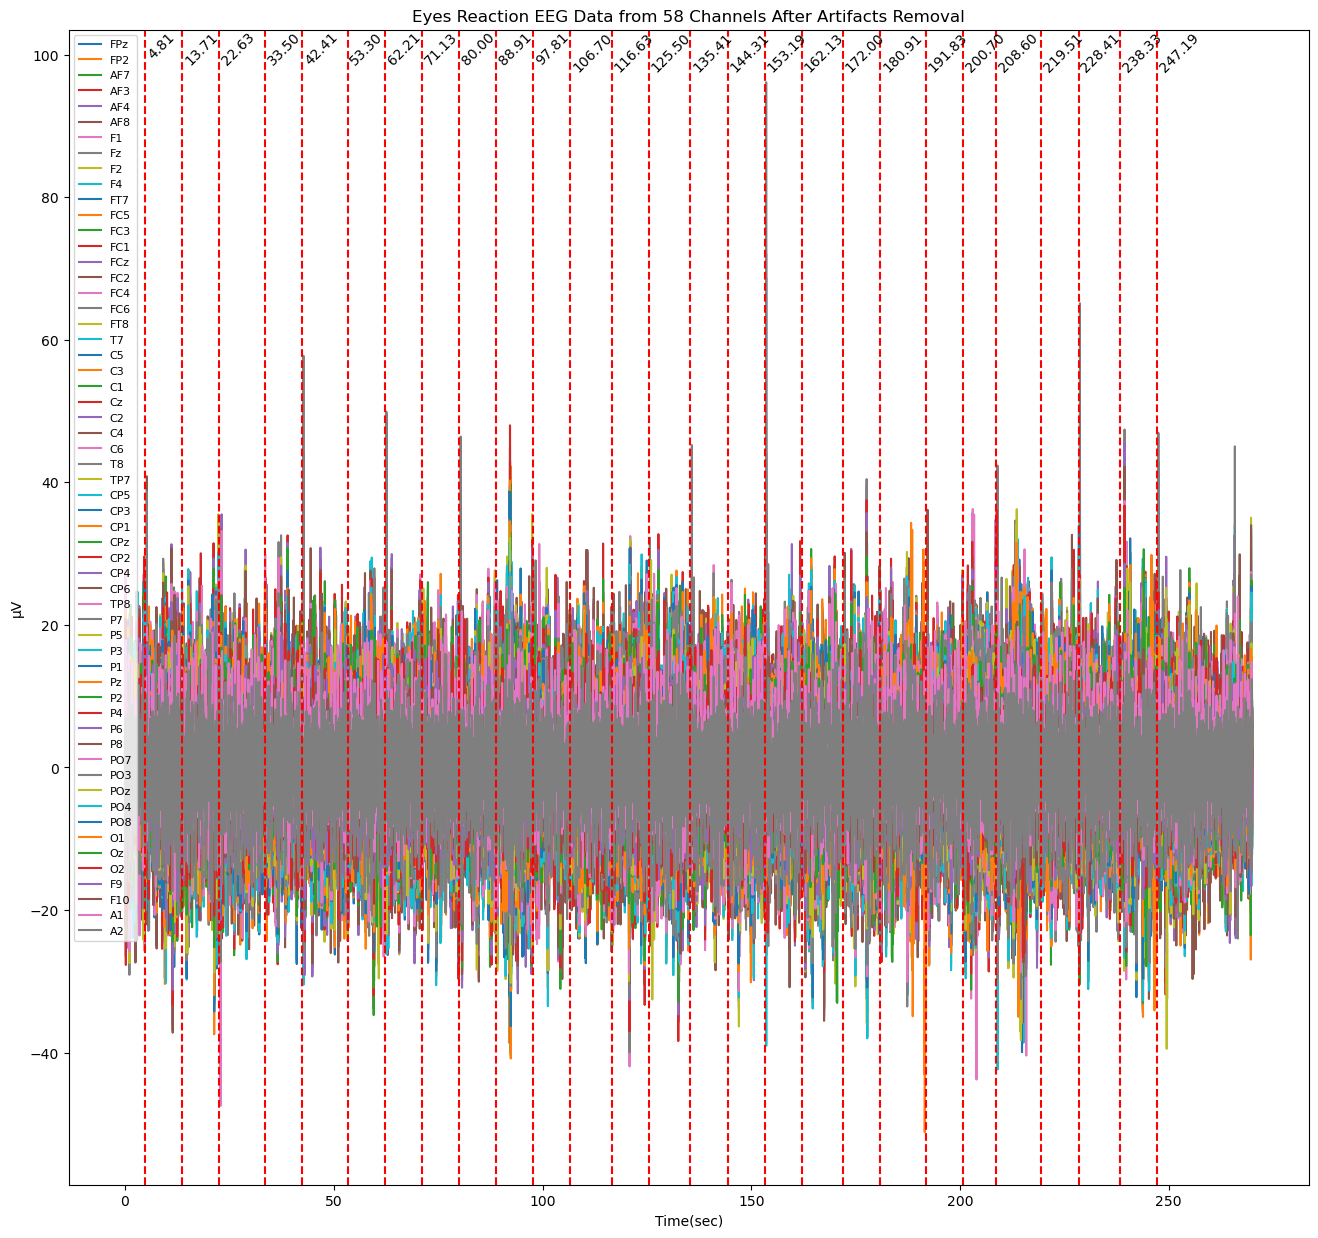

In [24]:
plotMNEData(mne_data=motor_icaed_eeg, domain='time', scaling=1e6, plt_x_range=(0,300),
            title='Eyes Reaction EEG Data from %d Channels After Artifacts Removal'%(len(motor_icaed_eeg.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            save_plt_to='icaed_motor_eeg.png', show_trigger=True, show_plt=True)

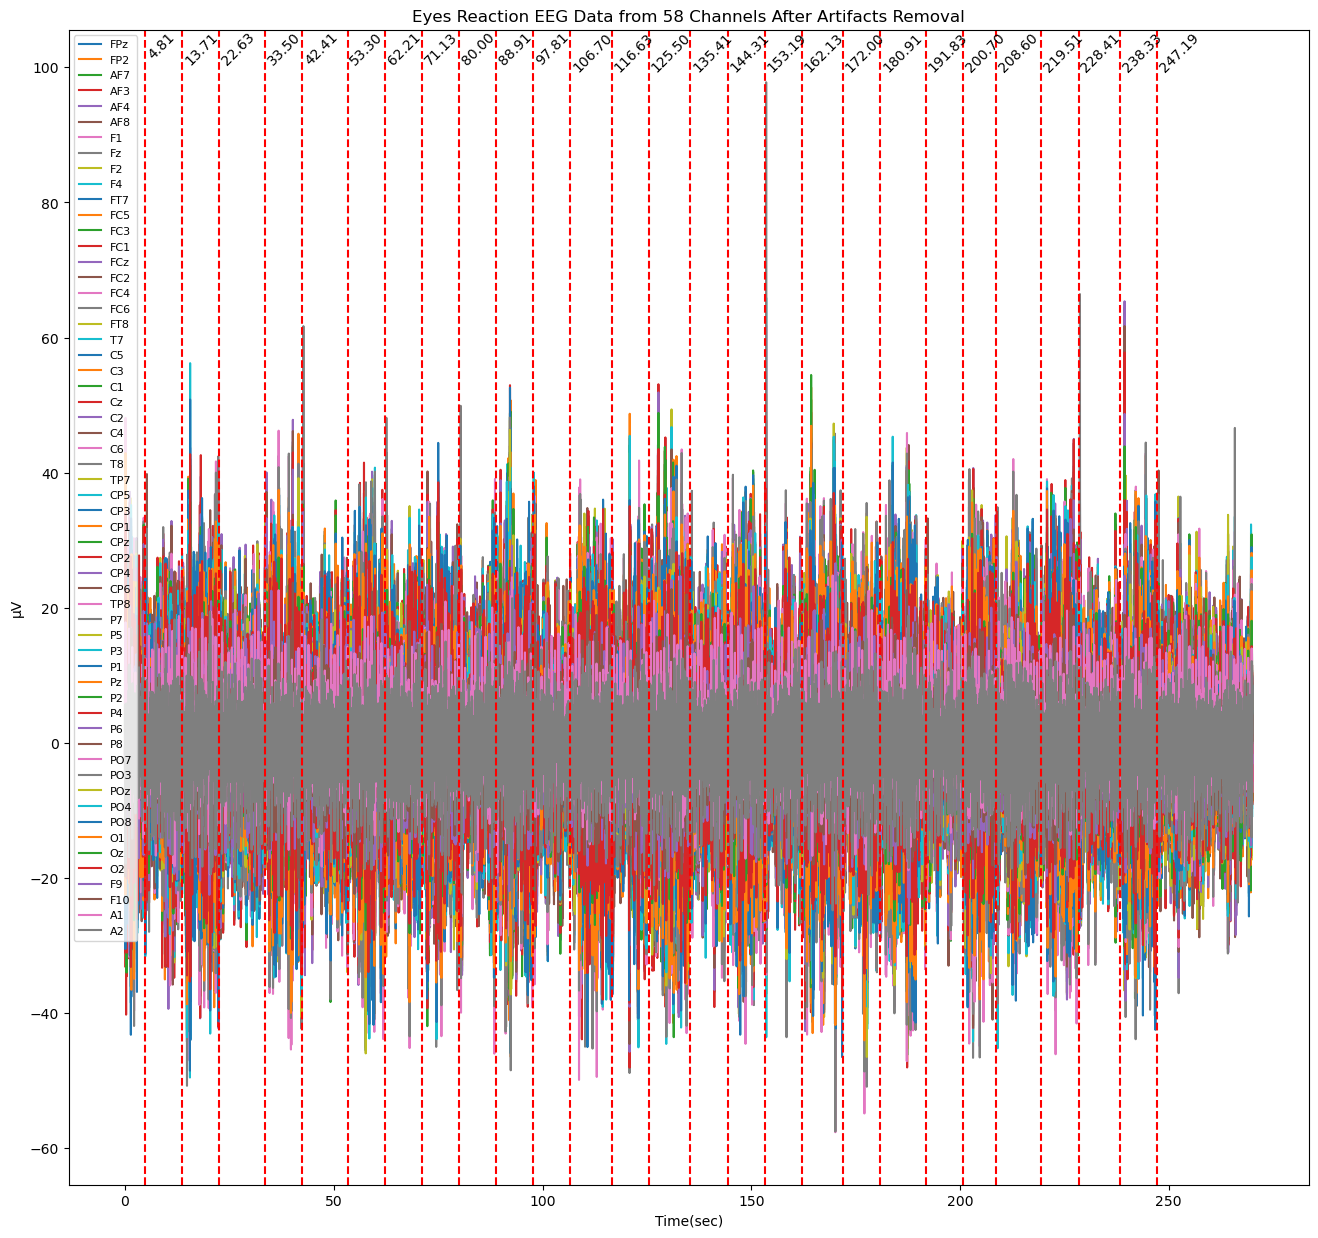

In [21]:
plotMNEData(mne_data=motor_icaed_eeg, domain='time', scaling=1e6, plt_x_range=(0,300),
            title='Eyes Reaction EEG Data from %d Channels After Artifacts Removal'%(len(motor_icaed_eeg.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            save_plt_to='icaed_motor_eeg.png', show_trigger=True, show_plt=True)

In [18]:
def genTFRFromEEGAnnot(eeg_arr, epoch_tmin, epoch_tmax, baseline=None, baseline_mode="percent", 
                       freqs_of_interest=(1,31), avg_across_epochs=False):
    # generate events from annotations in eeg data
    events_from_annot, event_dict = mne.events_from_annotations(eeg_arr)
    print(event_dict)
    # generate epochs for the events
    epochs = mne.Epochs(motor_icaed_eeg,events_from_annot,event_id=event_dict,
                        tmin=epoch_tmin,tmax=epoch_tmax,baseline=None,preload=True)
    # compute time-frequency representation for the epoched data
    freqs_arr = np.arange(freqs_of_interest[0], freqs_of_interest[1])
    eeg_tfr = epochs.compute_tfr(method="multitaper",freqs=freqs_arr,n_cycles=freqs_arr,
                                 use_fft=True,return_itc=False,average=avg_across_epochs,decim=2)
    
    if baseline:
        eeg_tfr.crop(epoch_tmin, epoch_tmax).apply_baseline(baseline, mode=baseline_mode)
    
    return eeg_tfr

In [27]:
motor_eeg_tfr = genTFRFromEEGAnnot(motor_icaed_eeg,-1,1.5,baseline=(-1,0), baseline_mode='mean')

Used Annotations descriptions: ['Eye_Close', 'Eye_Open']
{'Eye_Close': 1, 'Eye_Open': 2}
Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 27 events and 1281 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.0s


Applying baseline correction (mode: mean)


In [30]:
motor_eeg_tfr.to_data_frame().head()

time  freq  epoch  condition       FPz       FP2       AF7       AF3  \
0 -1.000000   1.0      0  Eye_Close -0.897876 -0.778750 -0.723139 -0.590374   
1 -0.996094   1.0      0  Eye_Close -0.898534 -0.776204 -0.718801 -0.583652   
2 -0.992188   1.0      0  Eye_Close -0.899417 -0.773934 -0.714822 -0.576909   
3 -0.988281   1.0      0  Eye_Close -0.900288 -0.771693 -0.711316 -0.570544   
4 -0.984375   1.0      0  Eye_Close -0.900925 -0.768403 -0.708284 -0.565060   

        AF4       AF8  ...       POz       PO4       PO8        O1        Oz  \
0 -0.533135 -0.689122  ... -0.415134 -0.889276 -0.842765 -0.447799 -0.703996   
1 -0.536595 -0.687526  ... -0.404721 -0.886401 -0.842504 -0.452376 -0.688351   
2 -0.539659 -0.685927  ... -0.395495 -0.882093 -0.841820 -0.454969 -0.674502   
3 -0.542390 -0.684306  ... -0.387718 -0.877104 -0.840762 -0.455879 -0.663126   
4 -0.544291 -0.682784  ... -0.381479 -0.872300 -0.839408 -0.455459 -0.654478   

         O2        F9       F10        A1        A2  
0 -0.855418 -0.949705 -0.819038  0.007487  0.007487  
1 -0.857805 -0.949216 -0.819560 -0.000405 -0.000405  
2 -0.858806 -0.948762 -0.820308 -0.009213 -0.009213  
3 -0.858970 -0.948321 -0.820561 -0.017711 -0.017711  
4 -0.859081 -0.947796 -0.819571 -0.025599 -0.025599  

[5 rows x 62 columns]

In [20]:
def computeAvgTFRPower(eeg_tfr, avg_over_ch='mean', condition:str=""):
    tfr_df = eeg_tfr.to_data_frame(time_format=None)
    # if condition is specified, and the specified condition exists in the EEG data
    # only take the rows in the dataframe that are with the specified condition value
    if condition and (condition in tfr_df['condition'].unique()):
        tfr_df = tfr_df[tfr_df['condition']==condition]

    # if average over mean, first compute mean over all channels
    if avg_over_ch == 'mean':
        tfr_df['mean'] = tfr_df.drop(columns=['time','freq','epoch','condition']).mean(axis=1)

    # Initialize numpy 2D array to contain average power values across all epochs(time windows around triggers)
    uniq_times = list(tfr_df['time'].unique())
    uniq_freqs = list(tfr_df['freq'].unique())
    uniq_freqs.reverse()
    avg_pw_arr = np.zeros((len(uniq_freqs),len(uniq_times)))

    # Compute average power for each unique (time,freq) pair, each pair should have 1 row for each epoch
    # hence the computed average will be the average power across all epochs
    uniq_time_freq = tfr_df[['time','freq']].value_counts().index
    for t,f in uniq_time_freq:
        avg_pw = tfr_df[(tfr_df['time'] == t) & (tfr_df['freq'] == f)][avg_over_ch].mean()
        avg_pw_arr[uniq_freqs.index(f),uniq_times.index(t)] = avg_pw

    return avg_pw_arr

In [21]:
def pltAvgTFRPowerHeatmap(eeg_tfr, plt_for_ch:str, plt_extents:list, plt_title:str="",
                          cnorm_vmin=None, cnorm_vmax=None, condition:str=""):
    # Compute average powers across all epochs
    tfr_avg_pw = computeAvgTFRPower(eeg_tfr,plt_for_ch,condition)

    # initialize color normalization 
    if cnorm_vmin and cnorm_vmax:
        cnorm = matplotlib.colors.TwoSlopeNorm(vmin=cnorm_vmin, vcenter=0, vmax=cnorm_vmax)
        plt.imshow(tfr_avg_pw, extent=plt_extents, aspect='auto',norm=cnorm,cmap='RdBu_r') 
    else:
        plt.imshow(tfr_avg_pw, extent=plt_extents, aspect='auto',cmap='RdBu_r') 
        
    plt.colorbar() 
    plt.title(plt_title) 
    plt.show()

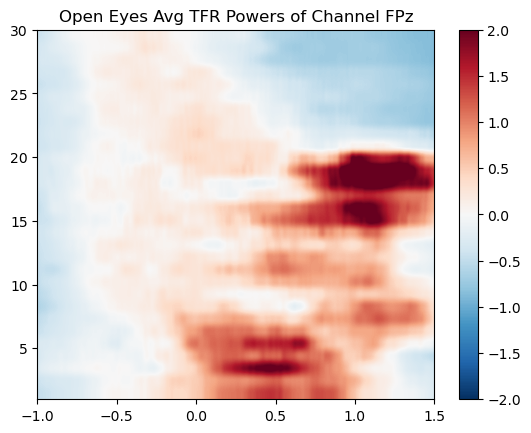

In [70]:
pltAvgTFRPowerHeatmap(motor_eeg_tfr, plt_for_ch='FPz', plt_extents=[-1,1.5,1,30], 
                      plt_title="Open Eyes Avg TFR Powers of Channel FPz", cnorm_vmin=-2, cnorm_vmax=2, 
                      condition="Eye_Open")

In [22]:
def pltAvgTFRPowerHeatmap(eeg_tfr, plot_for_ch, plt_title:str="",cnorm_vmin=None, 
                          cnorm_vmax=None, condition:str=""):
    # Compute average powers across all epochs (of specified condition)
    if condition and (condition in eeg_tfr.event_id):
        avg_tfr = eeg_tfr[condition].average(method='mean', dim='epochs')
    else:
        avg_tfr = eeg_tfr.average(method='mean', dim='epochs')

    # initialize color normalization 
    if cnorm_vmin and cnorm_vmax:
        cnorm = matplotlib.colors.TwoSlopeNorm(vmin=cnorm_vmin, vcenter=0, vmax=cnorm_vmax)
        avg_tfr.plot(plot_for_ch,cnorm=cnorm,title=plt_title)
    else:
        avg_tfr.plot(plot_for_ch)

No baseline correction applied


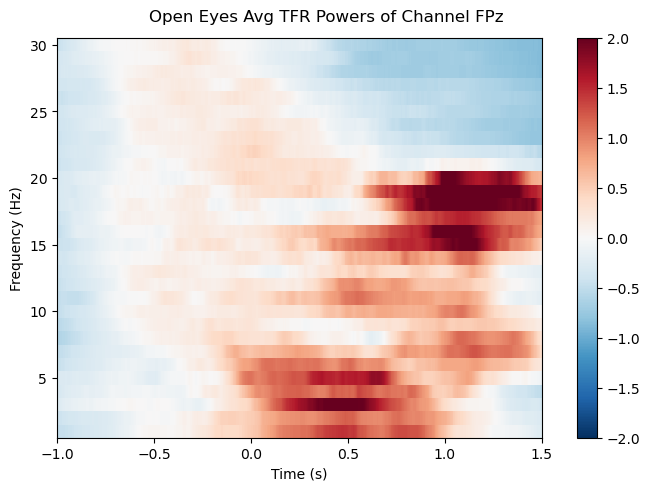

In [23]:
pltAvgTFRPowerHeatmap(motor_eeg_tfr, ['FPz'], plt_title="Open Eyes Avg TFR Powers of Channel FPz",
                      cnorm_vmin=-2, cnorm_vmax= 2, condition="Eye_Open")

No baseline correction applied


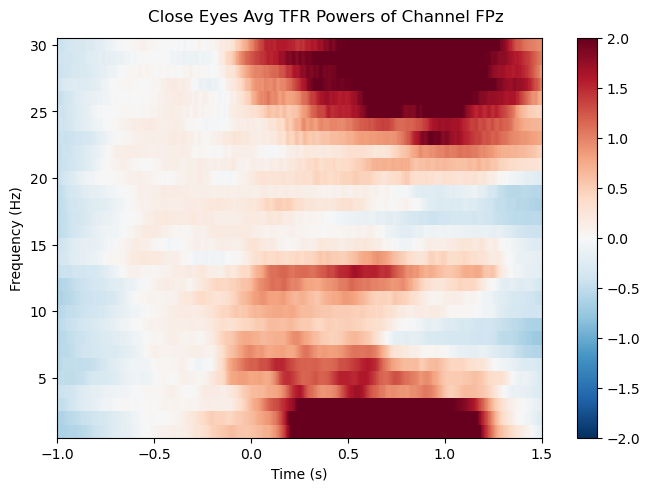

In [24]:
pltAvgTFRPowerHeatmap(motor_eeg_tfr, ['FPz'], plt_title="Close Eyes Avg TFR Powers of Channel FPz",
                      cnorm_vmin=-2, cnorm_vmax= 2, condition="Eye_Close")

No baseline correction applied


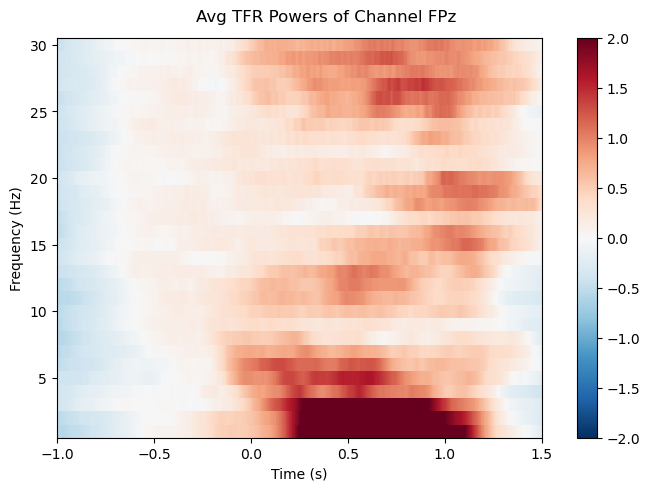

In [25]:
pltAvgTFRPowerHeatmap(motor_eeg_tfr, ['FPz'], plt_title="Avg TFR Powers of Channel FPz",
                      cnorm_vmin=-2, cnorm_vmax= 2)

In [66]:
# Average the TFR power across all epochs when generating the TFR from annotations
# the result values would be different from when averaging the powers after generating the TFR (what has been done above)
#avg_motor_eeg_tfr = genTFRFromEEGAnnot(motor_icaed_eeg,-1,1.5,baseline=(-1,0),avg_across_epochs=True)

In [67]:
# Note here the heatmaps below would be different from the heatmaps above
#avg_motor_eeg_tfr.plot(["FPz"],cnorm=cnorm)

In [30]:
FREQ_BOUNDS = {"_": 1, "delta": 4, "theta": 8, "alpha": 12, "beta": 30}

def plotERDSFromTFR(eeg_tfr, channels=[], show_param_channels=False, avg_across_epochs=False, condition:str=""):
    if avg_across_epochs:
        if condition and (condition in eeg_tfr.event_id):
            df = eeg_tfr[condition].average(method='mean', dim='epochs').to_data_frame(time_format=None, long_format=True)
        else:
            df = eeg_tfr.average(method='mean', dim='epochs').to_data_frame(time_format=None, long_format=True)
    else:
        if condition and (condition in eeg_tfr.event_id):
            df = eeg_tfr[condition].to_data_frame(time_format=None, long_format=True)
        else:
            df = eeg_tfr.to_data_frame(time_format=None, long_format=True)

    # Map to frequency bands:
    df["band"] = pd.cut(
        df["freq"], list(FREQ_BOUNDS.values()), labels=list(FREQ_BOUNDS)[1:]
    )

    # Filter to retain only relevant frequency bands and exclude channels that are not to be shown:
    freq_bands_of_interest = ["delta", "theta", "alpha", "beta"]
    df = df[df['band'].isin(freq_bands_of_interest)]
    
    if show_param_channels:
        df = df[df['channel'].isin(channels)]
    else:
        df = df[~df['channel'].isin(channels)]
        
    df["band"] = df["band"].cat.remove_unused_categories()
    df["channel"] = df["channel"].cat.remove_unused_categories()


    g = sns.FacetGrid(df, row="band", margin_titles=True, aspect=2.5)
    g.map(sns.lineplot, "time", "value", "channel", n_boot=10)
    axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
    g.map(plt.axhline, y=0, **axline_kw)
    g.map(plt.axvline, x=0, **axline_kw)
    g.set_axis_labels("Time (s)", "ERDS")
    g.set_titles(row_template="{row_name}")
    g.add_legend()


Converting "channel" to "category"...
Converting "ch_type" to "category"...


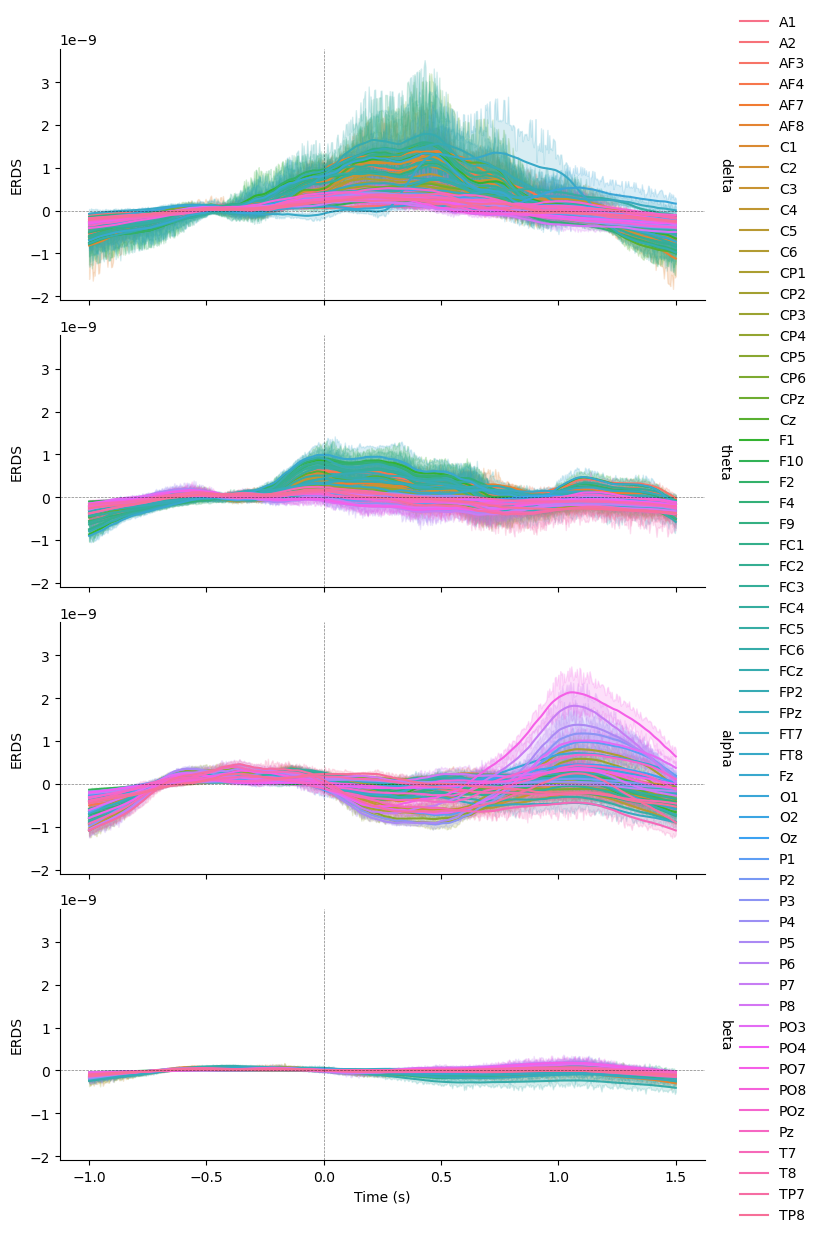

In [31]:
plotERDSFromTFR(motor_eeg_tfr,channels=[], show_param_channels=False, avg_across_epochs=True, condition='Eye_Open')

Converting "channel" to "category"...
Converting "ch_type" to "category"...


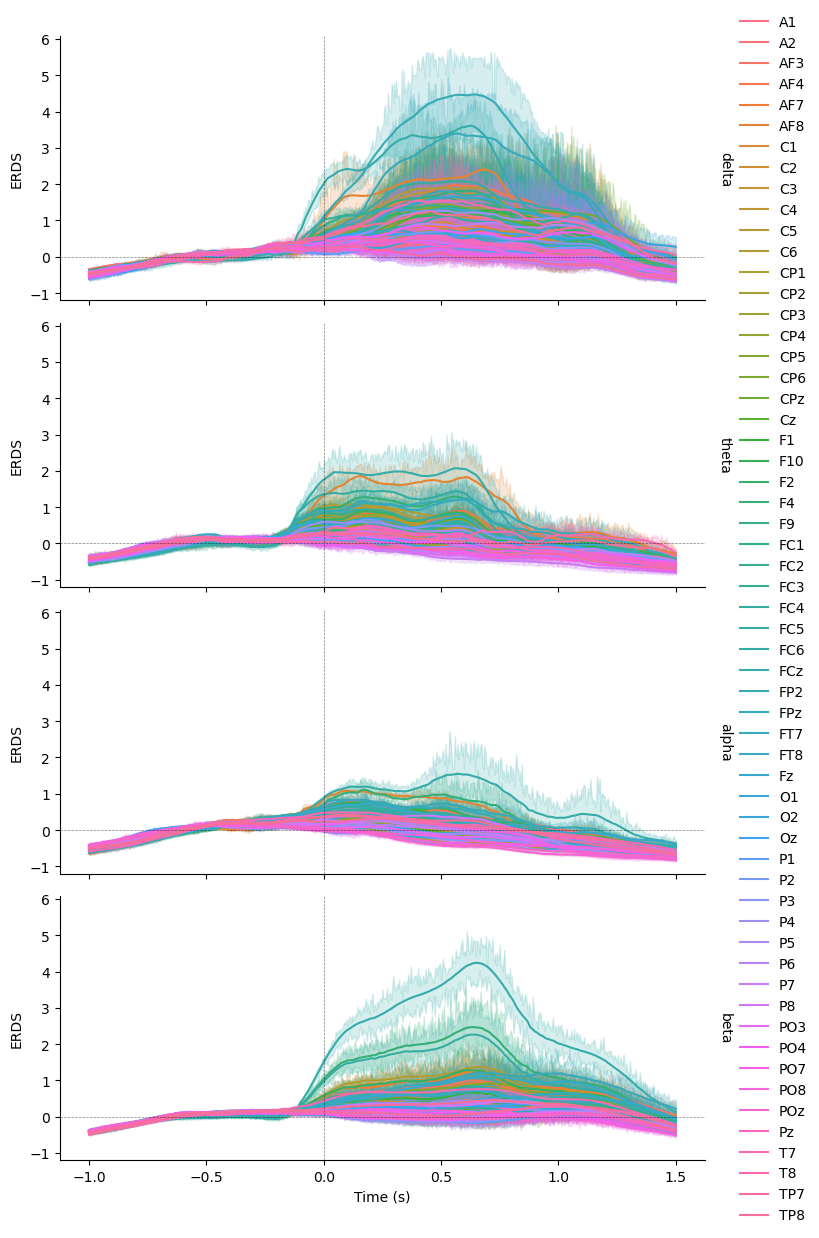

In [77]:
plotERDSFromTFR(motor_eeg_tfr,channels=[], show_param_channels=False, avg_across_epochs=True, condition='Eye_Close')

Converting "channel" to "category"...
Converting "ch_type" to "category"...


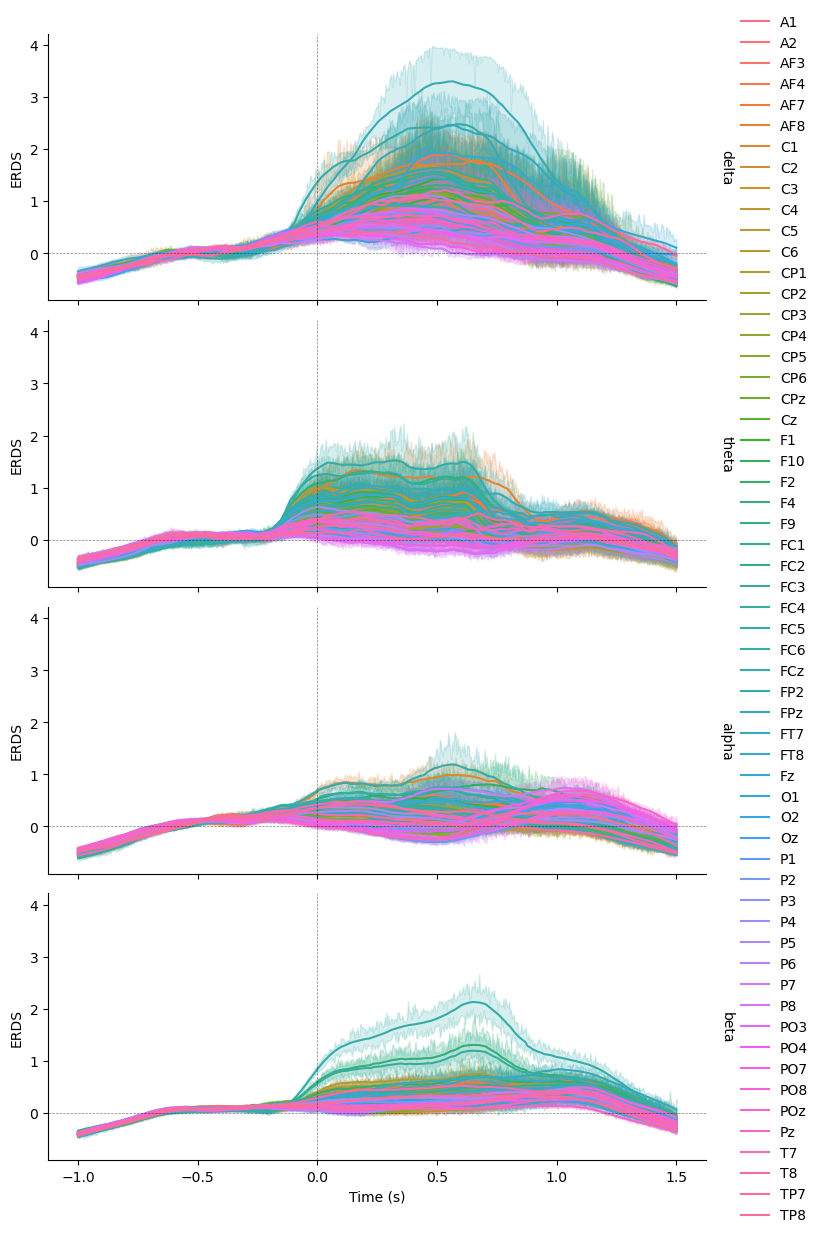

In [78]:
plotERDSFromTFR(motor_eeg_tfr,channels=[], show_param_channels=False, avg_across_epochs=True)

In [79]:
#plotERDSFromTFR(avg_motor_eeg_tfr,channels=[], show_param_channels=False, avg_across_epochs=False)

In [32]:
easycap_montage = mne.channels.make_standard_montage('standard_1020')
# Rename motor execution/imagery EEG TFR channel names to match the names in the montage
# For eye reaction2024.04.15_11.24.09
montage_rename_mapping = {'Fp2':'Fp1','FPz':'Fpz'}
motor_eeg_tfr.rename_channels(montage_rename_mapping)

# Setup montage for EEG data
motor_eeg_tfr.set_montage(easycap_montage)

AttributeError: 'EpochsTFR' object has no attribute 'rename_channels'